In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize, Bounds, LinearConstraint

In [43]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/Markowitz/5_Industry_Portfolios.CSV', header=6)

df_5 = df.iloc[1109:1169]

df_5 = df_5.rename(columns={'Unnamed: 0': 'Date'})

df_5['Date'] = pd.to_datetime(df_5['Date'], format='%Y%m')

df_5.set_index('Date', inplace=True)

df_5 =df_5.apply(pd.to_numeric, errors='coerce')

df_10 = df.iloc[1049:1169]

df_10 = df_10.rename(columns={'Unnamed: 0': 'Date'})

df_10['Date'] = pd.to_datetime(df_10['Date'], format='%Y%m')

df_10.set_index('Date', inplace=True)

df_10 =df_10.apply(pd.to_numeric, errors='coerce')

In [44]:
ret_5 = df_5.values / 100
var_5 = np.var(ret_5, axis=0, keepdims=True)
std_5 = np.sqrt(np.var(ret_5, axis=0, keepdims=True))

ret_10 = df_10.values / 100
var_10 = np.var(ret_10, axis=0, keepdims=True)
std_10 = np.sqrt(np.var(ret_10, axis=0, keepdims=True))


# Plage des rendements cibles
target_returns = np.linspace(-0.10, 0.10, num=100)  # Génère 100 valeurs entre -10% et 10%

rf = 0.44 / 100

z_bar_5 = np.transpose(np.mean(ret_5, axis=0, keepdims=True))
sigma_5 = np.cov(ret_5, rowvar=False)

z_bar_10 = np.transpose(np.mean(ret_10, axis=0, keepdims=True))
sigma_10 = np.cov(ret_10, rowvar=False)

## Analytique

In [45]:
z_barre = np.mean(ret_5, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

# Inversion de la matrice de covariance
Sigma_inv = np.linalg.inv(sigma_5)

# Construction de la matrice A et du vecteur b
A = np.array([
    [np.dot(ones, np.dot(Sigma_inv, ones)), np.dot(ones, np.dot(Sigma_inv, Z_barre))],
    [np.dot(Z_barre, np.dot(Sigma_inv, ones)), np.dot(Z_barre, np.dot(Sigma_inv, Z_barre))]
])
b = np.array([1, R_cible])

# Inversion de la matrice A
A_inv = np.linalg.inv(A)

# Résolution pour obtenir les multiplicateurs de Lagrange
lambda_theta = np.dot(A_inv, b)

# Calcul des poids optimaux du portefeuille
w_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)

print("Lambda (lambda_theta[0]) :", lambda_theta[0])
print("Theta (lambda_theta[1]) :", lambda_theta[1])
print("Poids optimaux du portefeuille :", w_optimal)

# Intervalle des rendements cibles pour la frontière efficiente
rendements_cibles_efficients = np.linspace(min(Z_barre), max(Z_barre), 100)

# Calcul des volatilités et des rendements pour la frontière efficiente
volatilites_optimales = []
rendements_optimaux = []
rf_tan = []

for R_cible in rendements_cibles_efficients:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(wi_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_5, wi_optimal)))
    rendements_optimaux.append(rendement_optimal)
    volatilites_optimales.append(volatilite_optimale)

# Étendre l'intervalle des rendements cibles pour la frontière complète
rendements_cibles_etendus = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 200)

# Calcul des volatilités et des rendements pour la frontière complète
volatilites_optimales_etendues = []
rendements_optimaux_etendus = []
for R_cible in rendements_cibles_etendus:
    b = np.array([1, R_cible])
    lambda_theta = np.dot(A_inv, b)
    wi_optimal = lambda_theta[0] * np.dot(Sigma_inv, ones) + lambda_theta[1] * np.dot(Sigma_inv, Z_barre)
    rendement_optimal = np.dot(wi_optimal, Z_barre)
    volatilite_optimale = np.sqrt(np.dot(wi_optimal.T, np.dot(sigma_5, wi_optimal)))
    rendements_optimaux_etendus.append(rendement_optimal)
    volatilites_optimales_etendues.append(volatilite_optimale)


# Risk-free rate (you need to define your risk-free rate)
rf = 0.0044

# Calculate the slope of the CML
CML_slope = (max(rendements_optimaux) - rf) / max(volatilites_optimales)

# Generate standard deviations for the CML
CML_std = np.linspace(0, max(volatilites_optimales), 100)

# Calculate corresponding expected returns for the CML
CML_ret = rf + CML_slope * CML_std

# Calculate Sharpe Ratios for all points on the efficient frontier
sharpe_ratios = [(r - rf) / v for r, v in zip(rendements_optimaux, volatilites_optimales)]

# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the return and volatility of the tangent portfolio
tangent_portfolio_return = rendements_optimaux[max_sharpe_index]
tangent_portfolio_volatility = volatilites_optimales[max_sharpe_index]

Lambda (lambda_theta[0]) : -0.0044084921297216206
Theta (lambda_theta[1]) : 1.232539348094809
Poids optimaux du portefeuille : [-8.06458381  2.46951304 13.70215328 -3.94462474 -3.16245777]


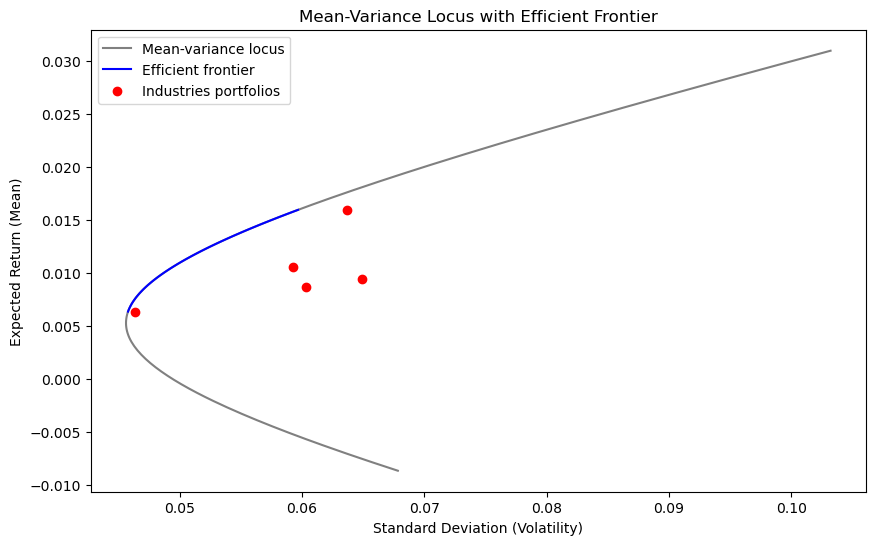

In [46]:
# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='grey')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.scatter(np.sqrt(np.diag(sigma_5)), Z_barre, color='red', label='Industries portfolios')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
#plt.grid(True)
plt.show()

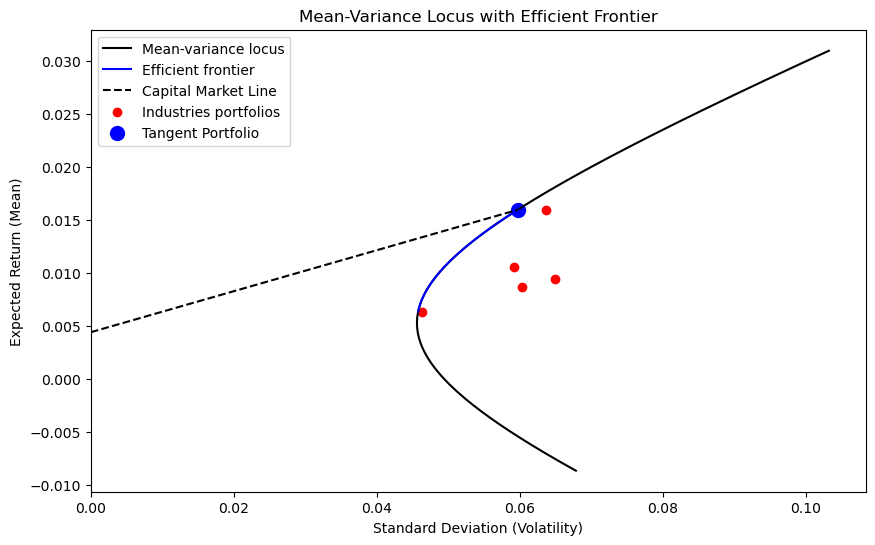

In [47]:
# Tracer la frontière complète et la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales_etendues, rendements_optimaux_etendus, label='Mean-variance locus', color='black')
plt.plot(volatilites_optimales, rendements_optimaux, label='Efficient frontier', color='blue')
plt.plot(CML_std, CML_ret, label='Capital Market Line', color='black', linestyle='--')
plt.scatter(np.sqrt(np.diag(sigma_5)), Z_barre, color='red', label='Industries portfolios')
plt.scatter(tangent_portfolio_volatility, tangent_portfolio_return, color='blue', marker='o', s=100, label='Tangent Portfolio')
plt.title('Mean-Variance Locus with Efficient Frontier')
plt.xlabel('Standard Deviation (Volatility)')
plt.ylabel('Expected Return (Mean)')
plt.legend()
plt.xlim(0)
plt.show()

In [48]:
# Find the index of the portfolio with the maximum Sharpe ratio
max_sharpe_index = np.argmax(sharpe_ratios)

# Extract the weights of the tangent portfolio
tangent_portfolio_weights = wi_optimal 

# Calculate the mean (expected return) of the tangent portfolio
tangent_portfolio_mean = rendements_optimaux[max_sharpe_index]

# Calculate the variance of the tangent portfolio
tangent_portfolio_variance = volatilites_optimales[max_sharpe_index] ** 2

# Print or use these values as needed
print("Tangent Portfolio Mean:", tangent_portfolio_mean)
print("Tangent Portfolio Variance:", tangent_portfolio_variance)
print("Tangent Portfolio Weights:", tangent_portfolio_weights)


Tangent Portfolio Mean: 0.01593333333333333
Tangent Portfolio Variance: 0.003561202294313256
Tangent Portfolio Weights: [-1.95344352  0.79855682  3.54188313 -0.39249158 -0.99450485]


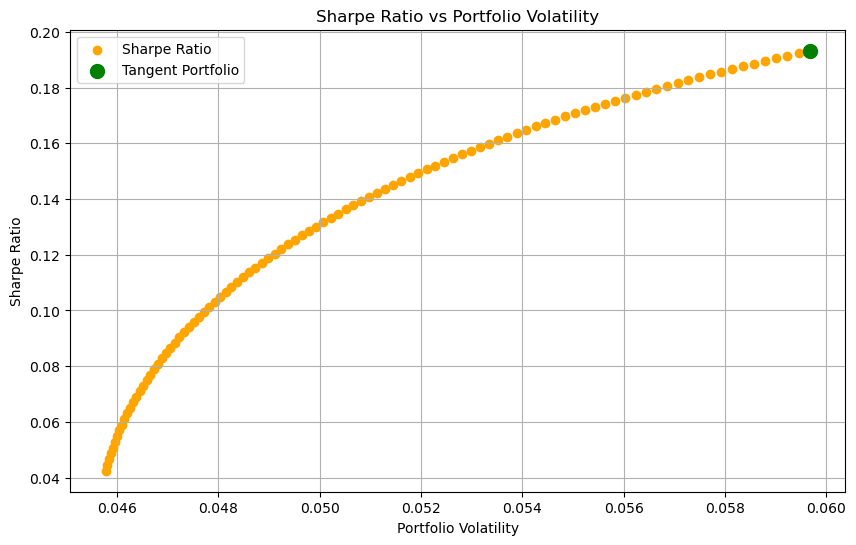

In [49]:
# Plot the Sharpe ratio against portfolio volatility
plt.figure(figsize=(10, 6))
plt.scatter(volatilites_optimales, sharpe_ratios, color='orange', label='Sharpe Ratio')

# Highlight the tangent portfolio
plt.scatter(tangent_portfolio_volatility, sharpe_ratios[max_sharpe_index], color='green', marker='o', s=100, label='Tangent Portfolio')

# Add labels and title
plt.title('Sharpe Ratio vs Portfolio Volatility')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Résolution numérique

In [50]:
z_barre_5 = np.mean(ret_5, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
Sigma_5 = np.cov(ret_5.T)
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

In [51]:
z_barre_10 = np.mean(ret_10, axis=0)  
Z_barre = z_barre  # Rendements espérés des actifs
Sigma_10 = np.cov(ret_10.T)
exp_ret = Z_barre
R_cible = 0.10  # Rendement espéré du portefeuille cible
ones = np.ones(len(Z_barre))  # Vecteur de uns

Poids optimaux du portefeuille : [-8.06458389  2.46950993 13.70215332 -3.94462396 -3.1624554 ]


/Users/dominicprenovost/anaconda3/envs/HECFinance/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


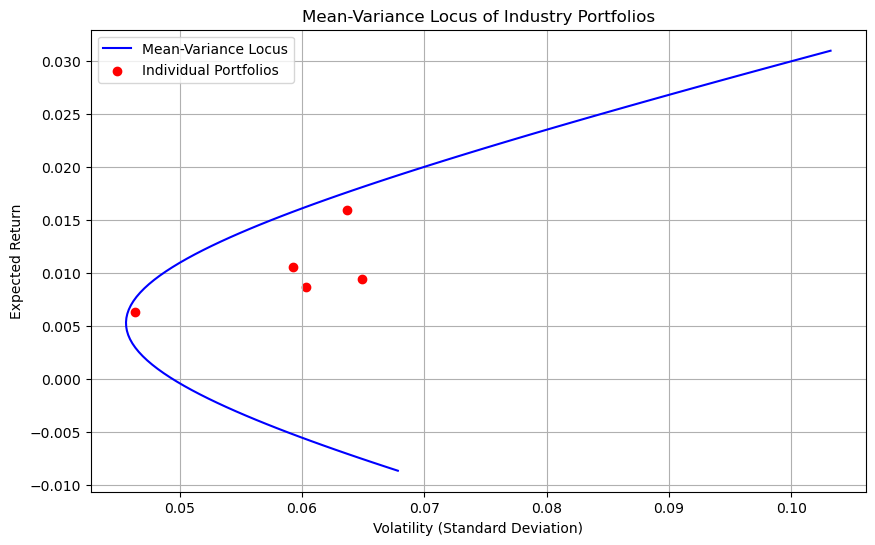

In [52]:
# Fonction objectif : Variance du portefeuille
def minportfolio_variance(W,Sigma_5):
    return W.T @ (Sigma_5 @ W)

# Poids initiaux : répartition uniforme
W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))

# Fonction d'optimisation
def optimize(func, W, Sigma_5, target_return):

    # Contraintes
    opt_constraints = ({'type': 'eq', 'fun': lambda W: ones @ W.T - 1},  # La somme des poids doit être égale à 1
                       {'type': 'eq', 'fun': lambda W: W.T @ z_barre - target_return})  # Le rendement attendu doit être égal au rendement cible

    # Optimisation
    optimal_weights = minimize(func, W, args=( Sigma_5), method='trust-constr', constraints=opt_constraints)

    return optimal_weights.x

# Appel de la fonction d'optimisation
optimal_weights = optimize(minportfolio_variance, W, Sigma_5, R_cible)

print("Poids optimaux du portefeuille :", optimal_weights)

# Générer une série de rendements cibles
rendements_cibles = np.linspace(min(Z_barre) - 0.015, max(Z_barre) + 0.015, 100)

# Initialiser les listes pour stocker les volatilités et rendements optimaux
volatilites_optimales = []
rendements_optimaux = []

# Itérer sur les rendements cibles pour optimiser les poids du portefeuille
for R_cible in rendements_cibles:
    W = np.ones(len(Z_barre)) * (1.0 / len(Z_barre))  # Réinitialiser les poids initiaux pour chaque itération
    poids_optimaux = optimize(minportfolio_variance, W, Sigma_5, R_cible)
    var_optimale = minportfolio_variance(poids_optimaux, Sigma_5)
    rendement_optimal = np.dot(poids_optimaux, Z_barre)

    volatilites_optimales.append(np.sqrt(var_optimale))
    rendements_optimaux.append(rendement_optimal)

# Tracer la frontière de variance moyenne
plt.figure(figsize=(10, 6))
plt.plot(volatilites_optimales, rendements_optimaux, 'b-', label='Mean-Variance Locus')
plt.scatter(np.sqrt(np.diag(Sigma_5)), Z_barre, color='red', label='Individual Portfolios')
plt.title('Mean-Variance Locus of Industry Portfolios')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)